## Deep Learning RNN

In [120]:
# importing function 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [95]:
rnn_df = pd.read_csv("data_with_features.csv", dtype='unicode')
rnn_df = rnn_df.drop(['Return-Path','Message-ID','From','Reply-To','To','Submitting Host','Subject','Date','X-Mailer','MIME-Version','Content-Type','X-Priority','X-MSMail-Priority','Status','Content-Length','Content-Transfer-Encoding','Lines'], axis = 1)
rnn_df

,Label,hops,special_characters_exists_subject,number_of_words_subject,number_of_capitalized_words_subject,number_of_capitalized_characters_subject,number_of_digits_subject,number_of_characters_subject,number_of_spaces_subject,number_of_special_characters_subject,number_of_single_Quotes_subject,number_of_semiColon_subject,ratio_of_uppercase/lowercase_words,Total_number_of_upperCase,Max_word_length_in_subject
0,1,3,0,4,0,0,0,19,4,0,0.0,0,0.0,0,9
1,0,2,0,3,0,0,0,9,2,0,0.0,0,0.0,0,6
2,0,9,1,6,3,7,0,15,6,4,0.0,0,1.0,3,8
3,1,1,0,3,0,2,0,12,2,0,0.0,0,0.0,0,7
4,0,6,0,2,0,1,0,2,1,0,0.0,0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62389,0,4,0,2,0,1,0,2,1,0,0.0,0,0.0,0,2
62390,0,1,1,4,0,1,7,7,3,1,0.0,0,0.0,0,6
62391,1,1,0,4,1,7,0,26,4,0,0.0,0,0.3333333333333333,1,11
62392,0,4,0,2,0,1,0,2,1,0,0.0,0,0.0,0,2


#### Split data for testing and training.

In [96]:
test_size = int(len(rnn_df) * 0.5)
train_data = rnn_df.iloc[:-test_size,:].copy()
test_data = rnn_df.iloc[-test_size:,:].copy()

#### Split training data into labels and features

In [97]:
features_train = train_data.drop('Label',axis=1).copy()
label_train = train_data[['Label']].copy()

#### Convert pandas dataframes to numpy arrays

In [98]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(features_train)
scaled_feature_train = feature_scaler.transform(features_train)

label_scaler = MinMaxScaler(feature_range=(0, 1))
label_scaler.fit(label_train)
scaled_label_train = label_scaler.transform(label_train)

scaled_label_train = scaled_label_train.reshape(-1)


scaled_label_train = np.insert(scaled_label_train, 0, 0)
scaled_label_train = np.delete(scaled_label_train, -1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Merge feature training and label training numpy arrays

In [99]:
n_input = 25 
n_features= features_train.shape[1]
b_size = 32
generator = TimeseriesGenerator(scaled_feature_train, scaled_label_train, length=n_input, batch_size=b_size)

print(generator[0][0].shape)

(32, 25, 14)


#### Instantiate the sequential model

In [102]:
model = Sequential()

model.add(LSTM(128, input_shape=(n_input, n_features), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 25, 128)           73216     
_________________________________________________________________
dropout_39 (Dropout)         (None, 25, 128)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

#### Train RNN model

In [103]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
975/975 [==============================] - 102s 104ms/step - loss: 0.6116 - acc: 0.6776
Epoch 2/5
975/975 [==============================] - 93s 96ms/step - loss: 0.5118 - acc: 0.7619
Epoch 3/5
975/975 [==============================] - 91s 93ms/step - loss: 0.4839 - acc: 0.7759
Epoch 4/5
975/975 [==============================] - 84s 86ms/step - loss: 0.4536 - acc: 0.7872
Epoch 5/5
975/975 [==============================] - 91s 93ms/step - loss: 0.4364 - acc: 0.7959


#### Plot losses per epoch

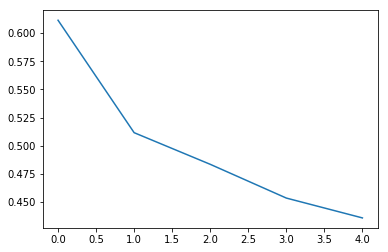

In [104]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

#### Split testing data into labels and features

In [105]:
features_test = test_data.drop('Label',axis=1).copy()
label_test = test_data[['Label']].copy()

#### Convert Test Data to numpy arrays

In [106]:
scaled_test_data = feature_scaler.transform(features_test)
test_generator = TimeseriesGenerator(scaled_test_data, np.zeros(len(test_data)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 25, 14)


#### Make predictions

In [122]:
pred_scaled = model.predict(test_generator)
pred = label_scaler.inverse_transform(pred_scaled)
results = pd.DataFrame({'true':test_data['Label'].values[n_input:],'pred':pred.ravel()})
results.loc[results.pred >= 0.5, 'pred'] = 1
results.loc[results.pred < 0.5, 'pred'] = 0
results['true'] = results['true'].astype(int)
results['pred'] = results['pred'].astype(int)
results

,true,pred
0,0,1
1,0,1
2,0,0
3,1,1
4,1,1
...,...,...
31167,0,1
31168,0,0
31169,1,1
31170,0,1


#### Calculate accuracy

In [124]:
accuracy = accuracy_score(results['true'], results['pred'])
precision = precision_score(results['true'], results['pred'])
recall = recall_score(results['true'], results['pred'])
print('Accuracy: %.2f\nPrecision: %.2f\nRecall: {recall}'.format(accuracy, precision, recall))

Accuracy: 0.5458745027588862
Precision: 0.6356900425450548
Recall: 0.6704986638430898
